In [1]:
# Basic dependencies
from qiskit import IBMQ, schedule, QuantumCircuit
import qiskit.pulse as pulse
from qiskit.circuit import QuantumCircuit, Gate
from qiskit.tools.monitor import job_monitor

from utility import *
from constant import *
from unitary_gate import *

import json
import numpy as np
import random
import matplotlib.pyplot as plt

if not IBMQ.active_account():
    IBMQ.load_account()
    
# We'll be using ibm_oslo, qubit 0 as the most suitable options that is currently available
provider = IBMQ.get_provider(hub='ibm-q', group='open', project='main')
backend = provider.get_backend('ibm_oslo')

%config InlineBackend.figure_formats = ['svg']

In [2]:
f = open('zo.json')
g = open('ot.json')

ot = json.load(g)
zo = json.load(f)

zo, ot

({'x_amp': 0.1729703647441323,
  'sx_amp': 0.08710130839410975,
  'dur': 160,
  'beta': 0.20754055952061876},
 {'x_amp': 0.138832273324212, 'sx_amp': None, 'dur': 160, 'beta': 0})

In [142]:
# Last revised 4th December 2022

drive_freq = backend.configuration().hamiltonian['vars'][f'wq{QUBIT}']/(2*np.pi)
anhar = (backend.properties().qubits[QUBIT][3].value)*1e9

def g01(theta, phi):
    with pulse.build(backend=backend) as g01:
        pulse.delay(48, pulse.drive_channel(QUBIT))
        pulse.set_frequency(drive_freq, pulse.drive_channel(QUBIT))
        with pulse.phase_offset(phi, pulse.drive_channel(QUBIT)):
            pulse.play(pulse.Drag(zo['dur'], theta*zo['x_amp']/pi, zo['dur']/4, zo['beta'], 
                                  r'$\mathcal{G}^{01}$'+f"({round(theta, 2)}, {round(phi, 2)})"),
                       pulse.drive_channel(QUBIT))
    return g01

def g12(theta, phi):
    with pulse.build(backend=backend) as g12:
        pulse.delay(48, pulse.drive_channel(QUBIT))
        pulse.set_frequency(drive_freq+anhar, pulse.drive_channel(QUBIT))
        with pulse.phase_offset(phi, pulse.drive_channel(QUBIT)):
            pulse.play(pulse.Drag(ot['dur'], theta*ot['x_amp']/pi, ot['dur']/4, ot['beta'], 
                                  r'$\mathcal{G}^{12}$'+f"({round(theta, 2)}, {round(phi, 2)})"),
                       pulse.drive_channel(QUBIT))
    return g12

x_01 = Gate(r'$\pi_x^{01}$', 1, [])
x_12 = Gate(r'$\pi_x^{12}$', 1, [])

prep0 = QuantumCircuit(1, 1)
prep0.measure(0, 0)

prep1 = QuantumCircuit(1, 1)
prep1.append(x_01, [0])
prep1.add_calibration(x_01, (0,), g01(theta=pi, phi=0), [])
prep1.measure(0, 0)

prep2 = QuantumCircuit(1, 1)
prep2.append(x_01, [0])
prep2.append(x_12, [0])
prep2.add_calibration(x_01, (0,), g01(theta=pi, phi=0), [])
prep2.add_calibration(x_12, (0,), g12(theta=pi, phi=0), [])
prep2.measure(0,0)

In [191]:
# samples need to be multiples of 16
def get_closest_multiple_of_16(num):
    return get_closest_multiple_of(num, 16)

def get_closest_multiple_of(vaule, base_number):
    return int(vaule + base_number/2) - (int(vaule + base_number/2) % base_number)

lcm = np.lcm(16, 1)

print(f"Least common multiple of acquire_alignment and pulse_alignment: {lcm}")
# Convert seconds to dt
def get_dt_from(sec):
    return get_closest_multiple_of(sec/dt, lcm)

backend_config = backend.configuration()
dt = backend_config.dt

us = 1e-6
ns = 1e-9
GHz = 1e9
MHz = 1e6

Least common multiple of acquire_alignment and pulse_alignment: 16


In [199]:
# Ramsey experiment parameters
time_max_sec = 1.8 * us
time_step_sec = 0.025 * us
delay_times_sec = np.arange(0, time_max_sec, time_step_sec)

# Drive parameters
# The drive amplitude for pi/2 is simply half the amplitude of the pi pulse
drive_amp = pi_amp / 2

# x_90 is a concise way to say pi_over_2; i.e., an X rotation of 90 degrees
with pulse.build(backend) as x90_pulse:
    drive_chan = pulse.drive_channel(QUBIT)
    pulse.delay(48, pulse.drive_channel(QUBIT))
    pulse.play(pulse.Gaussian(duration=zo['dur'],
                              amp=zo['sx_amp'],
                              sigma=zo['dur']/4,
                              name='x90_pulse'), drive_chan)
    
detuning_MHz = 2 
rough_qubit_frequency = backend.configuration().hamiltonian['vars'][f'wq{QUBIT}']/(2*np.pi)
ramsey_frequency = round(rough_qubit_frequency + detuning_MHz * MHz, 6) # need ramsey freq in Hz

# create schedules for Ramsey experiment 
delay = Parameter('delay')
with pulse.build(backend=backend, default_alignment='sequential', name="Ramsey delay Experiment") as ramsey_schedule:
    drive_chan = pulse.drive_channel(QUBIT)
    pulse.set_frequency(ramsey_frequency, drive_chan)
    pulse.call(x90_pulse)
    pulse.delay(delay, drive_chan)
    pulse.call(x90_pulse)
    
ramsey_gate = Gate("ramsey", 1, [delay])

qc_ramsey = QuantumCircuit(1, 1)

qc_ramsey.append(ramsey_gate, [0])
qc_ramsey.measure(0, 0)
qc_ramsey.add_calibration(ramsey_gate, (0,), ramsey_schedule, [delay])

exp_ramsey_circs = [qc_ramsey.assign_parameters({delay: get_dt_from(d)}, inplace=False) for d in delay_times_sec]
package = [prep0, prep1, prep2]
package = package+exp_ramsey_circs


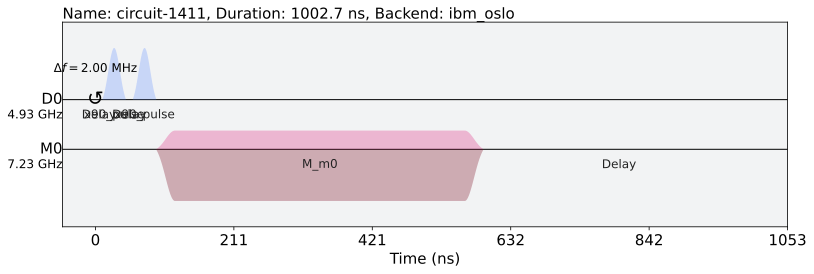

In [200]:
package_sched = schedule(package[3], backend)
package_sched.draw(backend=backend)

In [201]:
# Execution settings
num_shots = 2048

job = backend.run(package, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job has successfully run


In [204]:
ramsey01 = DataAnalysis(experiment=job, num_shots=2048)
ramsey01.retrieve_data(average=False)
ramsey01.lda()
ramsey01.count_pop()
ramsey01.error_mitiq()
#ramsey01.mitiq_data

In [205]:
delay_times_sec = np.array(delay_times_sec)/us

[]

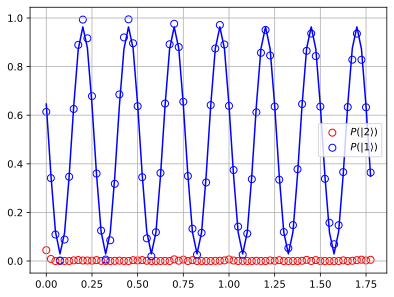

In [214]:
(fit_params, y_fit) = fit_function(delay_times_sec,
                                   ramsey01.mitiq_data[3:, 1], 
                                   lambda x, A, del_f_MHz, phi, B: A*cos(2*pi*del_f_MHz*x+phi)+B,
                                   [1, 3.5, 0, 0.25])

_, del_f_MHz, _, _, = fit_params

plt.figure()
plt.scatter(delay_times_sec, ramsey01.mitiq_data[3:, 2], s=50, facecolors='none', edgecolors='r', label=r'$P(|2\rangle)$')
plt.scatter(delay_times_sec, ramsey01.mitiq_data[3:, 1], s=50, facecolors='none', edgecolors='b', label=r'$P(|1\rangle)$')
plt.plot(delay_times_sec, y_fit, color='b')
#plt.axvline(phase4, linestyle="-", color="gray", linewidth=1.8, label=r'Dynamical phase correction $\phi=$ '+f'{round(phase4, 4)}')
plt.grid()
plt.legend()
#plt.xlabel(r"$\phi$")
#plt.ylabel(r"$P(|\alpha\rangle)$")
plt.savefig('fig/ramsey01.png', dpi=300)
plt.plot()

In [222]:
delay_times_sec

array([0.   , 0.025, 0.05 , 0.075, 0.1  , 0.125, 0.15 , 0.175, 0.2  ,
       0.225, 0.25 , 0.275, 0.3  , 0.325, 0.35 , 0.375, 0.4  , 0.425,
       0.45 , 0.475, 0.5  , 0.525, 0.55 , 0.575, 0.6  , 0.625, 0.65 ,
       0.675, 0.7  , 0.725, 0.75 , 0.775, 0.8  , 0.825, 0.85 , 0.875,
       0.9  , 0.925, 0.95 , 0.975, 1.   , 1.025, 1.05 , 1.075, 1.1  ,
       1.125, 1.15 , 1.175, 1.2  , 1.225, 1.25 , 1.275, 1.3  , 1.325,
       1.35 , 1.375, 1.4  , 1.425, 1.45 , 1.475, 1.5  , 1.525, 1.55 ,
       1.575, 1.6  , 1.625, 1.65 , 1.675, 1.7  , 1.725, 1.75 , 1.775])

In [209]:
precise_qubit_freq = rough_qubit_frequency + (detuning_MHz - del_f_MHz) * MHz # get new freq in Hz
print(f"Our updated qubit frequency is now {round(precise_qubit_freq/GHz, 6)} GHz. "
      f"It used to be {round(rough_qubit_frequency / GHz, 6)} GHz")

Our updated qubit frequency is now 4.923046 GHz. It used to be 4.925048 GHz


# Weird

In [227]:
rough_qubit_frequency, precise_qubit_freq

(4925048056.693643, 4923046309.996493)

In [228]:
with pulse.build(backend=backend) as sx_def:
    pulse.delay(48, pulse.drive_channel(QUBIT))
    pulse.set_frequency(rough_qubit_frequency, pulse.drive_channel(QUBIT))
    pulse.play(pulse.Drag(zo['dur'], zo['sx_amp'], zo['dur']/4, zo['beta']), pulse.drive_channel(QUBIT))
    
with pulse.build(backend=backend) as sx_pres:
    pulse.delay(48, pulse.drive_channel(QUBIT))
    pulse.set_frequency(precise_qubit_freq, pulse.drive_channel(QUBIT))
    pulse.play(pulse.Drag(zo['dur'], zo['sx_amp'], zo['dur']/4, zo['beta']), pulse.drive_channel(QUBIT))

In [229]:
sx_01 = Gate('SX', 1, [])

qc1 = QuantumCircuit(1,1)
qc1.append(sx_01, [0])
qc1.append(sx_01, [0])
qc1.measure(0, 0)
qc1.add_calibration(sx_01, (0,), sx_def, [])

qc2 = QuantumCircuit(1,1)
qc2.append(sx_01, [0])
qc2.append(sx_01, [0])
qc2.measure(0, 0)
qc2.add_calibration(sx_01, (0,), sx_pres, [])

package = [prep0, prep1, prep2, qc1, qc2]

In [230]:
# Execution settings
num_shots = 2048

job = backend.run(package, 
                  meas_level=1, 
                  meas_return='single', 
                  shots=num_shots)

job_monitor(job)

Job Status: job is queued (14)    

IBMQJobApiError: '"HTTPSConnectionPool(host=\'api.quantum-computing.ibm.com\', port=443): Max retries exceeded with url: /api/Network/ibm-q/Groups/open/Projects/main/Jobs/63ef388df0238492af2d054d/status/v/1 (Caused by NewConnectionError(\'<urllib3.connection.HTTPSConnection object at 0x12cddc790>: Failed to establish a new connection: [Errno 8] nodename nor servname provided, or not known\'))"'

In [231]:
job = backend.retrieve_job('63ef388df0238492af2d054d')

In [232]:
sx = DataAnalysis(experiment=job, num_shots=2048)
sx.retrieve_data(average=False)
sx.lda()
sx.count_pop()
sx.error_mitiq()
#sx.mitiq_data

In [233]:
sx.mitiq_data

array([[1.00000000e+00, 2.77555756e-17, 0.00000000e+00],
       [2.77555756e-17, 1.00000000e+00, 0.00000000e+00],
       [1.20563282e-16, 0.00000000e+00, 1.00000000e+00],
       [8.09404829e-03, 9.20737771e-01, 7.11681803e-02],
       [2.81277614e-01, 7.10759676e-01, 7.96270995e-03]])